## Getting topic modeling right . . . 

What went wrong?

1.  I assumed that "LDA" means "LDA" (i.e., that all "LDA" are equivalent).  They aren't.  See [**Radim Řehůřek's take on gensim LDA vs Mallet**](https://rare-technologies.com/tutorial-on-mallet-in-python/).
2.  I wasn't focused sufficiently on demonstrating credible results.

Note also that all tf-idf are not equivalent; compare gensim results vs those returned by the formula we learned in class.  See also, for example, the selection of variations detailed in [the td-idf Wikipedia article](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Definition).

So, do over . . . 

## . . . plus, some clustering

### Load spacy . . . 

In [1]:
import spacy

print spacy.__version__

nlp = spacy.load('en')

2.0.11


### Metadata

In [2]:
import glob

metadata = []

for path_to_file in glob.glob('corpora/inaugural_addresses/*.txt'):
    
    address_n = int(path_to_file.split('/')[-1].split('_')[0])
    address_year = int(path_to_file.split('/')[-1].split('_')[-1].replace('.txt', ''))
    president = '_'.join(path_to_file.split('/')[-1].split('_')[1:-1])
    
    metadata.append({'address_n': address_n, 
                     'address_year': address_year, 
                     'president': president, 
                     'path_to_file': path_to_file})
    
metadata.sort(key=lambda address: address['address_n'])

for m in metadata[:5]:
    print m
    

{'address_year': 1789, 'president': 'washington', 'address_n': 1, 'path_to_file': 'corpora/inaugural_addresses/1_washington_1789.txt'}
{'address_year': 1793, 'president': 'washington', 'address_n': 2, 'path_to_file': 'corpora/inaugural_addresses/2_washington_1793.txt'}
{'address_year': 1797, 'president': 'adams_john', 'address_n': 3, 'path_to_file': 'corpora/inaugural_addresses/3_adams_john_1797.txt'}
{'address_year': 1801, 'president': 'jefferson', 'address_n': 4, 'path_to_file': 'corpora/inaugural_addresses/4_jefferson_1801.txt'}
{'address_year': 1805, 'president': 'jefferson', 'address_n': 5, 'path_to_file': 'corpora/inaugural_addresses/5_jefferson_1805.txt'}


### Load corpus, first pass . . . 

I'm taking on pass so I can compute document frequencies for the words in the corpus (ie., for each word, the number of documents it appears in divided by the number of documents in the corpus). Because I'm not using textacy in this notebook, I need to roll my own document frequency filter.

In [3]:
import codecs, re

def process_text(path_to_file):
    
    tokens = []
    
    doc = nlp(codecs.open(path_to_file, 'r', encoding='utf-8').read())
    
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT'] and \
            token.tag_ not in ['PRP', 'PRP$'] and \
            token.is_stop == False and token.lemma_ not in ['\'s']:
                
            tokens.append(token.lemma_)
                
    return tokens

# --------------------------------------------------

tokenized_corpus = [process_text(m['path_to_file']) for m in metadata]

print 'len(tokenized_corpus)', len(tokenized_corpus)

print
for a, text in enumerate(tokenized_corpus[:10]):
    print metadata[a]['address_year'], metadata[a]['president'], len(text)

print
print tokenized_corpus[1]

len(tokenized_corpus) 58

1789 washington 597
1793 washington 57
1797 adams_john 1002
1801 jefferson 741
1805 jefferson 930
1809 madison 493
1813 madison 524
1817 monroe 1462
1821 monroe 1888
1825 adams_john_quincy 1293

[u'call', u'voice', u'country', u'execute', u'function', u'chief', u'magistrate', u'when', u'occasion', u'proper', u'shall', u'arrive', u'shall', u'endeavor', u'express', u'high', u'sense', u'entertain', u'distinguished', u'honor', u'confidence', u'repose', u'people', u'united', u'america', u'previous', u'execution', u'official', u'act', u'president', u'constitution', u'require', u'oath', u'office', u'this', u'oath', u'presence', u'that', u'shall', u'find', u'administration', u'government', u'instance', u'violate', u'willingly', u'knowingly', u'injunction', u'thereof', u'incur', u'constitutional', u'punishment', u'subject', u'upbraiding', u'witness', u'present', u'solemn', u'ceremony']


### Find document frequencies . . . 

 . . . by leveraging gensim's TfidfModel which, once created, contains a dictionary "dfs" which contains the raw (i.e., unscaled) count of the number of documents in which each word in the corpus appears.

In [36]:
from gensim import corpora, models, similarities

gensim_dictionary = corpora.Dictionary(tokenized_corpus)
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in tokenized_corpus]
tfidf_model = models.TfidfModel(gensim_corpus)

document_frequencies = dict([(gensim_dictionary[word], (float(document_count) / len(tokenized_corpus))) 
                             for word, document_count in tfidf_model.dfs.iteritems()])

print
print 'person', tfidf_model.dfs[gensim_dictionary.token2id['person']]
print 'government', tfidf_model.dfs[gensim_dictionary.token2id['government']]
print 'canal', tfidf_model.dfs[gensim_dictionary.token2id['canal']]
print
print 'len(gensim_dictionary)', len(gensim_dictionary)
print 'len(tfidf_model.dfs)', len(tfidf_model.dfs)
print 'len(document_frequencies)', len(document_frequencies)
print
print 'person', document_frequencies['person']
print 'government', document_frequencies['government']
print 'canal', document_frequencies['canal']


person 14
government 53
canal 3

len(gensim_dictionary) 5156
len(tfidf_model.dfs) 5156
len(document_frequencies) 5156

person 0.241379310345
government 0.913793103448
canal 0.051724137931


### Load corpus, second pass . . . 

 . . . this time for real (i.e., I'm actually going to use this corpus).
 
Note that this corpus is nothing more than a list (one item per text) of lists (one item per token) of strings.

Note also that I can't quite seem to make my mind up.  The first pass, and the document frequency disctionary, used lemma; however, the corpus that results from this will contain lower-cased, non-lemmatized words.  Note also that, if I were even slightly more creating, I might have written process_text just once.

**Why the need for a document frequency filter?**  Based on [a fair amount of testing](https://github.com/spenteco/understanding_mallet), I learned that Mallet does a poor job of correctly assigning low df and high df words to the correct topic.

In [5]:
import codecs, re

def process_text(path_to_file, document_frequencies, low_df, high_df):
    
    tokens = []
    
    doc = nlp(codecs.open(path_to_file, 'r', encoding='utf-8').read())
    
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT'] and \
            token.tag_ not in ['PRP', 'PRP$'] and \
            token.is_stop == False and token.lemma_ not in ['\'s'] and \
            document_frequencies[token.lemma_] > low_df and \
            document_frequencies[token.lemma_] < high_df:
                
            tokens.append(token.text.lower())
                
    return tokens

# --------------------------------------------------

tokenized_corpus = [process_text(m['path_to_file'], document_frequencies, 0.05, 0.95) for m in metadata]

print 'len(tokenized_corpus)', len(tokenized_corpus)

print
for a, text in enumerate(tokenized_corpus[:10]):
    print metadata[a]['address_year'], metadata[a]['president'], len(text)

print
print tokenized_corpus[1]

len(tokenized_corpus) 58

1789 washington 514
1793 washington 54
1797 adams_john 834
1801 jefferson 665
1805 jefferson 836
1809 madison 449
1813 madison 439
1817 monroe 1307
1821 monroe 1633
1825 adams_john_quincy 1141

[u'called', u'voice', u'country', u'execute', u'functions', u'chief', u'magistrate', u'when', u'occasion', u'proper', u'shall', u'arrive', u'shall', u'endeavor', u'express', u'high', u'sense', u'entertain', u'distinguished', u'honor', u'confidence', u'reposed', u'united', u'america', u'previous', u'execution', u'official', u'act', u'president', u'constitution', u'requires', u'oath', u'office', u'this', u'oath', u'presence', u'that', u'shall', u'found', u'administration', u'government', u'instance', u'violated', u'knowingly', u'injunctions', u'thereof', u'incurring', u'constitutional', u'punishment', u'subject', u'witnesses', u'present', u'solemn', u'ceremony']


### gensim: load corpus, topic model

https://rare-technologies.com/tutorial-on-mallet-in-python/


https://radimrehurek.com/gensim/models/ldamallet.html


https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

This is the big change: Here, I use gensim's wrapper for Mallet, a topic modeling toolkit written in Java, with which we have considerable experience.  To run it, you need to 

1.  Have Java installed on your laptop (version?);
2.  Download and unzip [the Mallet package](http://mallet.cs.umass.edu/download.php).
3.  Modify the code to call mallet so that it contains the path to the mallet executable on your laptop (e.g., '/home/spenteco/0/mallet-2.0.7/bin/mallet' in the code below), which will be wherever you unzipped the Mallet package:

        lda_model = LdaMallet('/home/spenteco/0/mallet-2.0.7/bin/mallet',
                                corpus=gensim_corpus, 
                                id2word=gensim_dictionary,
                                optimize_interval=10,
                                num_topics=N_TOPICS)
                                
The "optimize_interval" setting tells mallet to tune its parameters every 10 iterations; we've found this setting words well for us.

num_topics is, as you might imagine, key here.  It you set it too low, Mallet will combine topics which should ideally be separated.  For example, if a corpus contains topics A, B, C, D, and E, and you set num_topics to 3, you might get something like AB (1st topic), CD (2nd) and E (3rd).  On the other hand, if you set number topics too high, Mallet will split topics; e.g., if a corpus contains topics A, B, C, D, and E, and you set num_topics to 6, you might get something line A1 (1st topic), A2 (2nd), B (3rd), etc.

In [6]:
from gensim import corpora, models, similarities
from gensim.models.wrappers import LdaMallet

N_TOPICS = 20

gensim_dictionary = corpora.Dictionary(tokenized_corpus)
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in tokenized_corpus]

print 'len(gensim_dictionary)', len(gensim_dictionary)
print 'len(gensim_corpus)', len(gensim_corpus)

print
for a, text in enumerate(gensim_corpus[:10]):
    print metadata[a]['address_year'], metadata[a]['president'], len(text)
    
lda_model = LdaMallet('/home/spenteco/0/mallet-2.0.7/bin/mallet',
                        corpus=gensim_corpus, 
                        id2word=gensim_dictionary,
                        optimize_interval=10,
                        num_topics=N_TOPICS)

gensim_lda_corpus = lda_model[gensim_corpus]

print
print 'len(gensim_lda_corpus)', len(gensim_lda_corpus)

print
for a, text in enumerate(gensim_lda_corpus[:10]):
    print metadata[a]['address_year'], metadata[a]['president'], len(text)

print
print 'gensim_lda_corpus[1]', gensim_lda_corpus[1]

len(gensim_dictionary) 5156
len(gensim_corpus) 58

1789 washington 413
1793 washington 51
1797 adams_john 563
1801 jefferson 496
1805 jefferson 574
1809 madison 385
1813 madison 358
1817 monroe 768
1821 monroe 909
1825 adams_john_quincy 728

len(gensim_lda_corpus) 58

1789 washington 20
1793 washington 20
1797 adams_john 20
1801 jefferson 20
1805 jefferson 20
1809 madison 20
1813 madison 20
1817 monroe 20
1821 monroe 20
1825 adams_john_quincy 20

gensim_lda_corpus[1] [(13, 0.6515250362165695), (4, 0.2270391935545439), (6, 0.07466991375634113), (19, 0.012076778410277869), (17, 0.010399077679443189), (15, 0.00525936631986514), (9, 0.003740007170567055), (18, 0.0036092415895854837), (14, 0.0017274862465487665), (1, 0.0014734834184224762), (5, 0.0012834767278001203), (7, 0.0011545801519433343), (16, 0.0011190337573614183), (12, 0.0010733187110095292), (10, 0.0007653850839416644), (8, 0.0007612890865245826), (3, 0.0006913135373259022), (2, 0.000583000263203194), (0, 0.0005695263326114797), 

## Report results

### What words are contained in each topic?

I'd like a slighly more convenient data format that the one provided by gensim . . . I'd like a dict of dicts, keyed by topic number, then token (the actual word, not the gensim id).

In [ ]:
from collections import defaultdict, Counter

topic_word_counts = defaultdict(lambda: defaultdict(int))

word_topics = lda_model.load_word_topics()

for topic_n, word_counts in enumerate(word_topics):
    for word_n, word_count in enumerate(word_counts):
        topic_word_counts[topic_n][gensim_dictionary[word_n]] = word_count

### Report the rresults for all the topics:

I'm only reporting a topic if at least one document contains at least 10% of the topic.   These topics seem explicable/interesting:

    Topic 5:   Madison and Monroe, "coastal fortifications"
    Topic 6:   The generic vocabulary of "the (long) American century"?
    Topic 13:  How is this different from topic 6?
    Topic 17:  Slavery
    Topic 18:  The language of early 20th century progressivism?
    Topic 19:  Pre-Civil-War
    

In [8]:
import textwrap
for topic_n in range(N_TOPICS):
    
    n_documents = 0
    for doc in gensim_lda_corpus:
        for t in doc:
            if t[0] == topic_n and t[1] > 0.1:
                n_documents += 1
                
    if n_documents > 0:
    
        print
        print 'Topic', topic_n
        print
        
        for a, doc in enumerate(gensim_lda_corpus):
            for t in doc:
                if t[0] == topic_n and t[1] > 0.1:
                    print '\t', '%.02f' % t[1], metadata[a]['address_year'], metadata[a]['president']
                    
        printed_words = []
        for w in Counter(topic_word_counts[topic_n]).most_common(50):
            printed_words.append(w[0] + ' ' + str(int(w[1])))
            
        print '\n\t' + '\n\t'.join(textwrap.wrap('; '.join(printed_words), 80))
        


Topic 0

	0.19 1981 reagan
	0.30 1985 reagan
	0.27 1989 bush_george_h_w

	n't 15; hand 10; federal 9; senator 9; bless 7; budget 5; prayer 5; tax 5;
	speaker 5; increase 4; fall 4; number 4; nuclear 4; heroes 4; deficit 4;
	engagement 3; union 3; working 3; sound 3; money 3; neighborhood 3; door 3;
	suffer 3; found 3; reverse 3; inflation 3; spend 3; lesson 3; putting 3; lines
	3; helped 3; weapon 3; victory 3; loyal 3; shown 3; george 3; arsenals 3;
	program 3; aimed 3; held 3; thousands 3; growth 3; misunderstanding 2; tomorrow
	2; begins 2; points 2; tempted 2; preserve 2; asked 2; soul 2

Topic 1

	0.26 1993 clinton
	0.17 1997 clinton
	0.19 2001 bush_george_w
	0.16 2005 bush_george_w
	0.35 2009 obama
	0.35 2013 obama
	0.31 2017 trump

	schools 12; journey 12; bless 12; jobs 11; families 11; care 9; crisis 8; creed
	7; hard 7; politics 7; ideals 7; birth 6; borders 6; action 6; blood 6; workers
	6; big 6; gift 6; civil 6; class 6; streets 6; mission 6; communities 6; united
	6; wat

### Report results . . . just for Truman

The "secret knowledge" here, which is not exposed in gensim's Mallet interface, is the Mallet "state" file, which I access in the line

        for line in gzip.open(lda_model.fstate(), 'rb').read().split('\n'):
        
The Mallet state file provides a text-by-text, word-by-word accounting for all of the individual words in the corpus at the time the Mallet run finished.  The state file is a gzip'd plain text file with the format like:

        #doc source pos typeindex type topic
        #alpha : 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 
        #beta : 0.01
        0 NA 0 0 accomplished 2
        0 NA 1 1 acknowledge 19
        0 NA 2 2 act 19
        0 NA 3 3 actual 15
        0 NA 4 4 add 14
        0 NA 5 5 addition 10
        0 NA 6 6 addressed 14
        0 NA 7 7 administration 10
        
The first line is a header, the next two lines contain information about Mallet's "hyperparameters" (watch the video), and each subsequent line reports on an individual word in the corpus.  The key parts of these subsequent lines are the first number, which is the number of the text in the input to mallet; the word (printed plainly) and the topic number (the last number on the line).



In [38]:
import gzip
import textwrap

#  Which document number in the corpus is Truman?  Which topics characterize his address?

truman_index = -1
for a in range(len(metadata)):
    if metadata[a]['president'] == 'truman':
          truman_index = a
            
truman_topics = []

for t in gensim_lda_corpus[truman_index]:
    if t[1] > 0.01:
        truman_topics.append(t[0])

#  Just for Truman, read the state file and generate two dictionaries of dictionaries
#  to faciliate easy topic-word and word-topic lookups.

truman_token_topic_counts = defaultdict(lambda: defaultdict(int))
truman_topic_token_counts = defaultdict(lambda: defaultdict(int))

for line in gzip.open(lda_model.fstate(), 'rb').read().split('\n'):
    if line.strip() > '' and line.startswith('#') == False:
        
        cols = line.strip().split(' ')
        
        doc_n = int(cols[0])
        token = cols[4]
        topic = int(cols[5])
        
        if doc_n == truman_index:
            
            truman_token_topic_counts[token][topic] += 1
            truman_topic_token_counts[topic][token] += 1
            
#  Finally, we report . . . first, just the topics, their percentages, and their words in Truman.

print
print metadata[truman_index]['address_n'], metadata[truman_index]['address_year'], metadata[truman_index]['president']
print

for t in gensim_lda_corpus[truman_index]:
    if t[0] in truman_topics:
        print
        print '\t', 'topic', t[0], '%.02f' % t[1]
                    
        printed_words = []
        for w in Counter(truman_topic_token_counts[t[0]]).most_common(50):
            printed_words.append(w[0] + ' ' + str(int(w[1])))
        
        print '\n\t' + '\n\t'.join(textwrap.wrap('; '.join(printed_words), 80))
        
#  And let's highlight Truman's address . . . Note how brittle this is.
        
tagged_tokens = []
for token in tokenized_corpus[truman_index]:
    
    topics = truman_token_topic_counts[token]
    
    if len(topics.keys()) == 0:
        tagged_tokens.append(token)
    elif len(topics.keys()) == 1:
        tagged_tokens.append('<span class="topic' + str(topics.keys()[0])  + '">' + token + '</span>')
    else:
        tagged_tokens.append('<span class="multiTopic">' + token + '</span>')
        
html_styles = """
<style>
.topic14 {
    color: #bf1e1e;
    font-weight: bold;
}
.topic6 {
    color: #5353c6;
    font-weight: bold;
}
.topic13 {
    color: #1dad1d;
    font-weight: bold;
}
.multiTopic {
    font-style: italic;
}
</style>
"""
        
from IPython.core.display import HTML
HTML(html_styles + \
     '<p><span class="topic14">topic14</span><br/>' + \
     '<span class="topic6">topic6</span><br/>' + \
     '<span class="topic13">topic13</span><br/>' + \
     '<span class="multiTopic">multiTopic</span><br/></p>' + \
     '<p style="padding-right: 100px;">' + ' '.join(tagged_tokens) + '</p>')
        
    


41 1949 truman


	topic 14 0.45

	world 13; countries 8; democracy 7; resources 6; economic 6; program 6; aided 5;
	nations 5; recovery 5; peace 5; human 4; areas 4; desire 4; agreement 4;
	philosophy 4; communism 3; based 3; justice 3; labor 3; aims 3; international 3;
	agencies 3; action 3; attack 3; prosperity 3; development 3; mankind 3;
	stability 2; concept 2; settlement 2; guarantees 2; unprecedented 2;
	developments 2; standards 2; courses 2; established 2; cooperation 2; conditions
	2; europe 2; scientific 2; key 2; advance 2; benefits 2; industrial 2; armed 2;
	working 2; basis 2; addition 2; opportunity 2; constantly 2

	topic 6 0.41

	freedom 13; world 10; peace 10; security 6; free 6; men 5; live 5; liberty 4;
	faith 4; life 4; differences 4; work 4; strengthen 4; united 4; man 4; communism
	3; knowledge 3; hope 3; continue 3; time 3; american 3; effort 3; history 3; god
	3; earth 2; fear 2; justice 2; hunger 2; mr. 2; government 2; resolve 2; benefit
	2; common 2; lastin

## Visualization, clustering, etc

Some useful resources are left over from the Mallet stuff above:

        tokenized_corpus (whole words, stopwords removed, filtered by document frequency)
        gensim_dictionary (from tokenized_corpus)
        gensim_corpus  (from tokenized_corpus)
        gensim_lda_corpus (the document results from Mallet)
        N_TOPICS, a constant used in topic modeling
       
You might start [**here**](http://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html).

**In what follows, I'm mostly interested in understanding the corpus in relation to Truman.**

### We always do this . . . 

. . . really, almost as a kind of ritual; we're really just asking, can we reduce the data down to two dimensions, preserve/explain the variation in the data, and get interpretable results?  **Is there a there there?**

**Explained variance ratio** is important; summed together, the two numbers explain how much of the original variation is preserved in the reduced dimension representation.  Here, 63% is, I suppose, okay.

[**The doc**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  And [**this**](http://scikit-learn.org/stable/modules/unsupervised_reduction.html#data-reduction).

lda_matrix.shape (20, 58)
lda_matrix.shape (58, 20)

58

explained_variance_ratio_ [ 0.57861859  0.06560806]


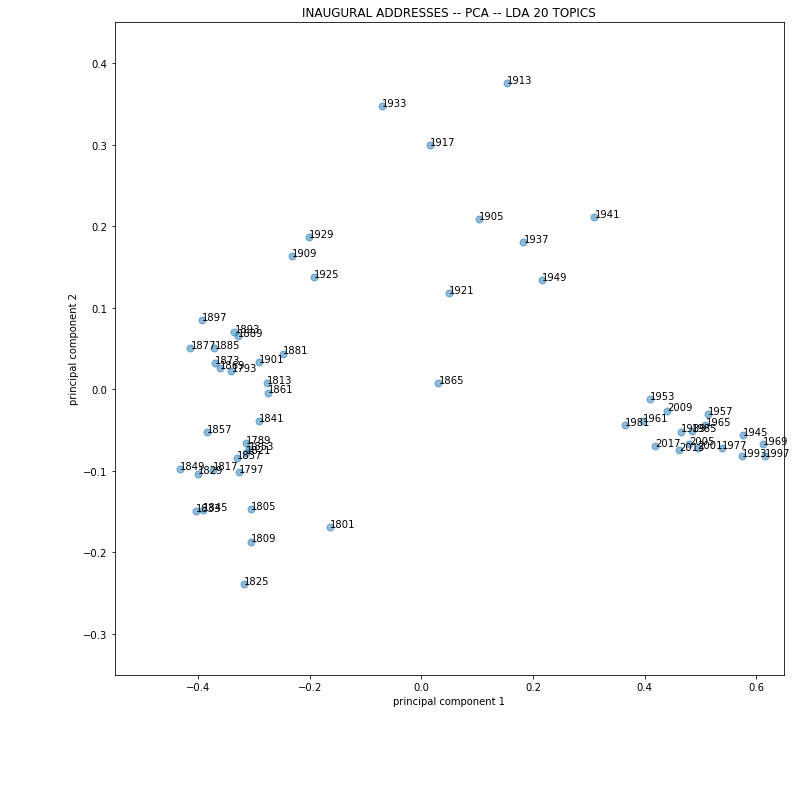

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from gensim.matutils import corpus2dense
import numpy as np
from sklearn.decomposition import PCA

lda_matrix = corpus2dense(gensim_lda_corpus, N_TOPICS)

print 'lda_matrix.shape', lda_matrix.shape

lda_matrix = lda_matrix.T

print 'lda_matrix.shape', lda_matrix.shape

pca = PCA(n_components=2)
results = pca.fit_transform(lda_matrix)

print
print len(results)
print
print 'explained_variance_ratio_', pca.explained_variance_ratio_

x = []
y = []
for r in results:
    x.append(r[0])
    y.append(r[1])

plt.figure(figsize=(12,12))

plt.title('INAUGURAL ADDRESSES -- PCA -- LDA 20 TOPICS')

plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

plt.ylim(-0.35, 0.45)
plt.xlim(-0.55, 0.65)

plt.scatter(x, y, s=50, alpha=.5)
    
for i, m in enumerate(metadata):
    plt.annotate(metadata[i]['address_year'], (x[i], y[i]))

### Clustering

http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

I like hiearchical clustering, presented as a dendrogram, because a) I don't know how many clusters can actually be found in the data; b) regard the distances between texts as more interesting than some arbitrary clustering; c) and prefer to manipulate the visual representation of clustering, such as it is (see the color_threshold in the call to dendrogram, below).

This dendrograph reflects a commonly seen behavior of topic modeling: texts tend be be closest to other texts written by the same person; notice, for example, that Madison's two addresses, Eisenhower's two, etc tend to be right next to each other.

Notice that Taft seems to be the farthest, in some sense, from everyone else.  I think that's because his address has a very bureaucratic section of excuses for problems with the Panama Canal.

And Truman is where we expect him to be: you have to traverse the distance of the whole graph to get to the Presidents who surround him in time.

distances.shape (1653,)
linkage_matrix.shape (57, 4)


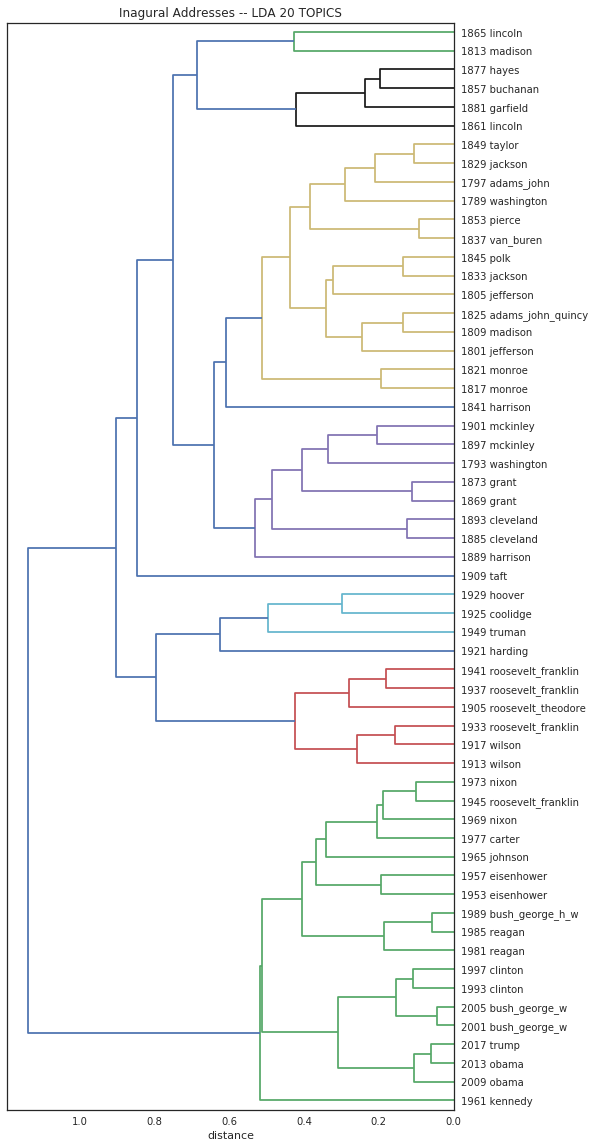

In [148]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# I DON'T NEED TO DO THIS UNLESS I WANT A DISTANCE METRIC OTHER THAN 'euclidean'.
# I.E., THIS IS DEMO CODE . . . 
distances = pdist(lda_matrix, 'euclidean')

print 'distances.shape', distances.shape

# THESE ARE EQUIVALENT
#linkage_matrix = linkage(lda_matrix, 'complete')
linkage_matrix = linkage(distances, 'complete')

print 'linkage_matrix.shape', linkage_matrix.shape

#linkage_matrix = linkage(lda_matrix, 'ward')
#linkage_matrix = linkage(lda_matrix, 'single')
#linkage_matrix = linkage(lda_matrix, 'average')
#linkage_matrix = linkage(lda_matrix, 'weighted')
#linkage_matrix = linkage(lda_matrix, 'centroid')
#linkage_matrix = linkage(lda_matrix, 'median')

row_labels = [str(m['address_year']) + ' ' + m['president'] for m in metadata]

sns.set_style("white")

plt.figure(figsize=(8, 20))
plt.title('Inagural Addresses -- LDA 20 TOPICS')
plt.ylabel('')
plt.xlabel('distance')
dendrogram(
    linkage_matrix,
    orientation='left',
    labels=row_labels,
    leaf_font_size=10,
    color_threshold=0.6
)
plt.show()


### A heatmap of distances, combined with heirarchical clustering

Note that I'm using need to transform the distances data twice, once to put it in a rectangular format (number of rows == number of columns == 58, or the number of inaugural addresses), and a second time to get it into a pandas data frame (seaborn looks for the figures labels in the dataframe).


[**Pandas**](https://pandas.pydata.org/) is a package which extends and elaborates the basic python list.  Pandas is a requirement (not absolure, but unavoidable) for almost all data science in python, as is [numpy](http://www.numpy.org/).  I recommend the book [**Python for data analysis**(http://catalog.wustl.edu:80/record=b5701531~S2), which is available electronically through the library.  If this were an eight-hour class, instead of a two hour class, we would have covered both . . . 

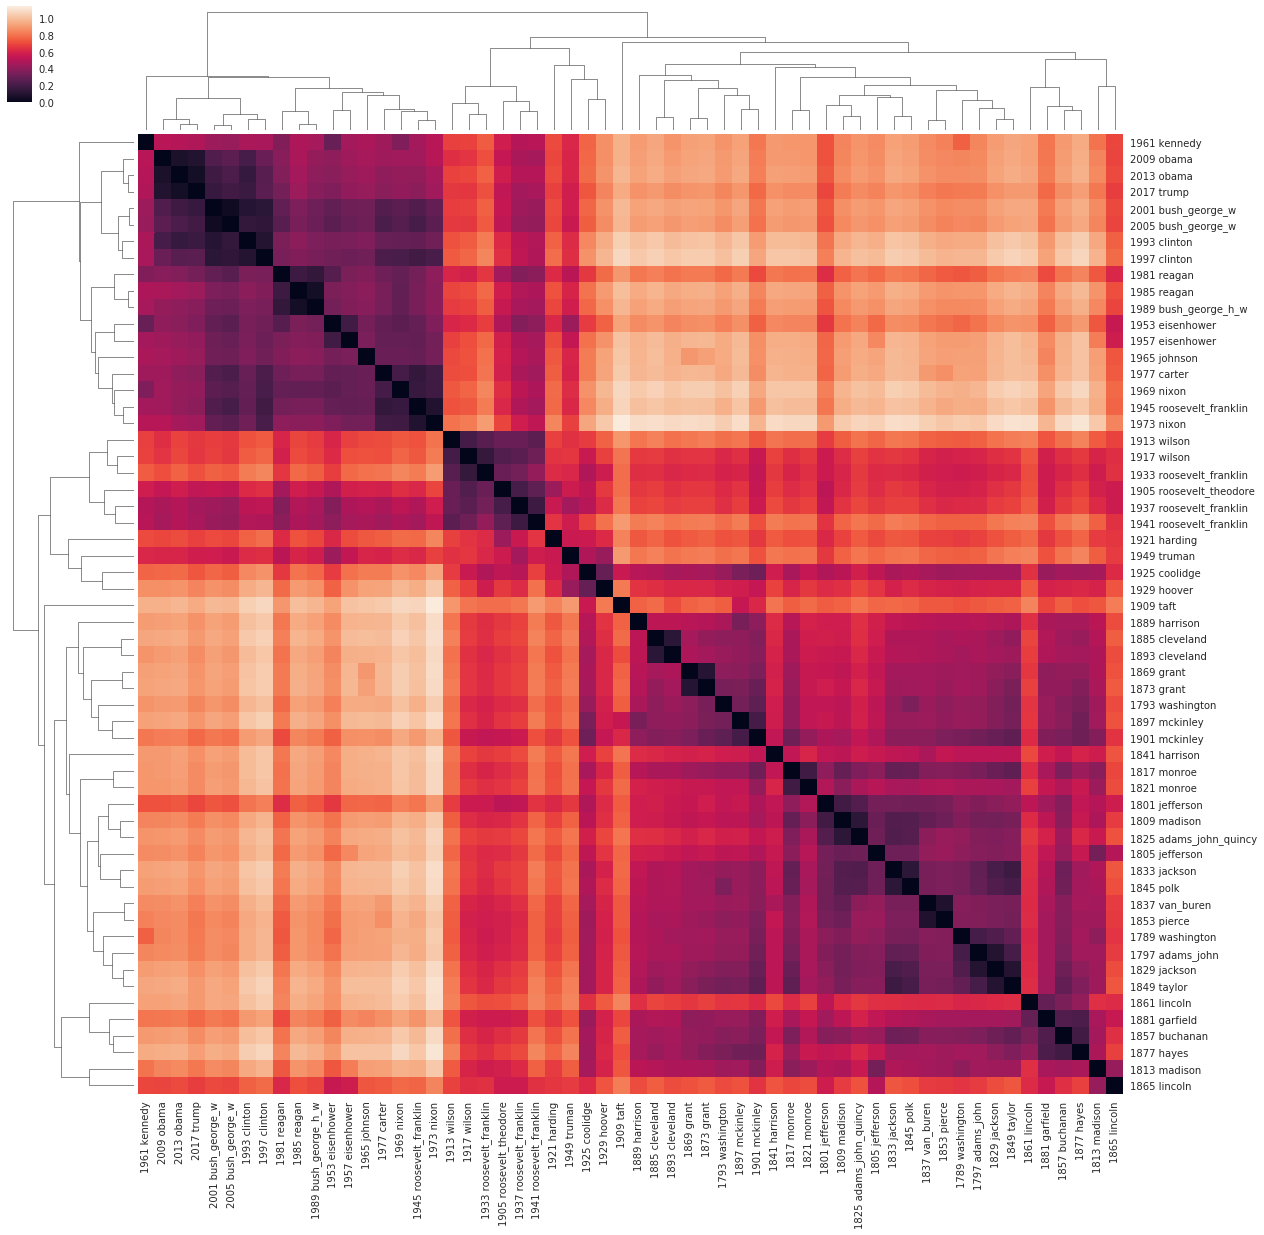

In [140]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
import pandas as pd

rectagular_distance_matrix = squareform(distances)

labels = [str(m['address_year']) + ' ' + m['president'] for m in metadata]

distance_data_frame = pd.DataFrame(rectagular_distance_matrix, index=labels, columns=labels)

sns.set(color_codes=True)

plt.figure(figsize=(40, 40))

g = sns.clustermap(distance_data_frame, 
                   row_linkage=linkage_matrix, 
                   col_linkage=linkage_matrix,
                   figsize=(20, 20))

### Trump and Obama?

The idea that Trump and Obama occupy the same space in the LDA matrix seems **ridiculous**.

What are the possible causes of this result?  From most important to least important, I think it's due to:

1.  The df filter reduces addresses in size; the effect is particularly pronounced in the case of Trump's address.  The next result is that the peculiar words ("carnage") are dropped.

2.  LDA doesn't account for sequence, syntactic dependencies; it's strictly a bag-of-words method.

3.  Both use similar words, although, I suspect, in different semantic contexts.  Other groups of Presidents show similar similarities; are elections about not just control over policies, but about the language surrounding policies?

4.  The Obama and Trump addresses were sourced differently from everthing else; what are the consequences of that.

In [165]:
!wc -w corpora/inaugural_addresses/*obama*
!wc -w corpora/inaugural_addresses/*trump*

 2394 corpora/inaugural_addresses/56_obama_2009.txt
 2106 corpora/inaugural_addresses/57_obama_2013.txt
 4500 total
1457 corpora/inaugural_addresses/58_trump_2017.txt


In [163]:
import textwrap

def get_year_and_president_index(year, president):

    i = -1
    for a in range(len(metadata)):
        if metadata[a]['address_year'] == year and metadata[a]['president'] == president:
              i = a
    return i

i_2009 = get_year_and_president_index(2009, 'obama')
i_2013 = get_year_and_president_index(2013, 'obama')
i_2017 = get_year_and_president_index(2017, 'trump')

words_2009 = set(tokenized_corpus[i_2009])
words_2013 = set(tokenized_corpus[i_2013])
words_2017 = set(tokenized_corpus[i_2017])

shared_words_2009_2017 = words_2009.intersection(words_2017)
shared_words_2013_2017 = words_2013.intersection(words_2017)

print
print 'len(words_2009)', len(words_2009), \
        'len(words_2017)', len(words_2017), \
        'len(shared_words_2009_2017)', len(shared_words_2009_2017)
        
print
print '\n'.join(textwrap.wrap(' '.join(sorted(shared_words_2009_2017)), 80))

print
print 'len(words_2013)', len(words_2013), \
        'len(words_2017)', len(words_2017), \
        'len(shared_words_2013_2017)', len(shared_words_2013_2017)
        
print
print '\n'.join(textwrap.wrap(' '.join(sorted(shared_words_2013_2017)), 80))
print


len(words_2009) 630 len(words_2017) 375 len(shared_words_2009_2017) 150

accept action alliances america american americans and at big bigger birth bless
blood borders born borne bridges build bush but came capital carry celebration
challenges child children citizens city come confidence cost country courage day
define demands destiny dollars earth effort enjoy example face factories fail
fallen families far fear fellow finally for forgotten forward free future gather
giving god government grateful hands harness heart homes horizon hour in
interests job jobs joined knowledge labor land law lead let life like live long
longer look loyalty magnificent meaning men minds moment new now oath obama
office old patriotism patriots politics power president promise prosper
prosperity protect public pursue ready remember restore roads schools seek
shores sights small so spirit stand starting states strength success system tell
thank that these this time today transition understand understanding 

In [168]:
!grep -il obama corpora/inaugural_addresses/*

corpora/inaugural_addresses/56_obama_2009.txt
corpora/inaugural_addresses/57_obama_2013.txt
corpora/inaugural_addresses/58_trump_2017.txt
